# Solving the Helmholtz equation
In this notebook we look at the problem of solving the Helmholtz equation (acoustic), where we start from an initial sound speed profile $c_{\text{initial}}$, and gradually perturb to a final sound speed profile $c_{\text{final}}$.

## Set the directory of the Python scripts

In [1]:
import sys
sys.path.append("G:\\Research\\Freq-Domain\\Godzilla\\Python")

## Import all the needed packages

In [3]:
from Common import Common
from Velocity import Velocity2D
from CreateGeometry import CreateGeometry2D
from CreateMatrixHelmholtz import CreateMatrixHelmholtz2D
from scipy.sparse.linalg import splu
import numpy as np
import scipy as sp
import time
import matplotlib.pyplot as plt

## Define experiment geometry, and frequency range of all simulations

In [4]:
# Define frequency parameters
omega_min = 10.0
omega_max = 100.0

# Define grid, and velocity range
v_min = 1.5
v_max = 3.0

# Print calculated grid spacings
lambda_min = 2 * np.pi * v_min / omega_max
lambda_max = 2 * np.pi * v_max / omega_min
print("Lambda min = " + str(lambda_min))
print("Lambda max = " + str(lambda_max))
print("\nCalculating grid spacing with minimum of 10 points per wavelength:\n")
print("Minimum cell spacing needed = " + str(lambda_min / 10))
print("Minimum cells needed for padding (based on calculated minimum cell spacing) = " 
      + str(np.ceil(10 * lambda_max / lambda_min)))

ncells_x = 300
ncells_z = 300
dx = 0.009
dz = 0.009
ncells_x_pad = 200
ncells_z_pad = 200

# Create geometry object, and set parameters
geom2d = CreateGeometry2D(
    xdim=dx * ncells_x,
    zdim=dz * ncells_z,
    vmin=v_min,
    vmax=v_max,
    omega_max=omega_max,
    omega_min=omega_min
)

geom2d.set_params(
    ncells_x=ncells_x,
    ncells_z=ncells_z,
    ncells_x_pad=ncells_x_pad,
    ncells_z_pad=ncells_z_pad,
    check=True
)
geom2d.set_default_sources()
geom2d.set_default_receivers()

Lambda min = 0.09424777960769379
Lambda max = 1.8849555921538759

Calculating grid spacing with minimum of 10 points per wavelength:

Minimum cell spacing needed = 0.00942477796076938
Minimum cells needed for padding (based on calculated minimum cell spacing) = 200.0


## Create initial and final velocity models

In [5]:
# Create an initial velocity model
vel_initial = Velocity2D(geometry2d=geom2d)
ngridpoints_x = geom2d.gridpointsX
ngridpoints_z = geom2d.gridpointsZ

# Create a final velocity model (Gaussian perturbation)
sigma_x = 0.3
sigma_z = 0.3
vel_final = Velocity2D(geometry2d=geom2d)
center_nx = int(ngridpoints_x / 2)
center_nz = int(ngridpoints_z / 2)
vel_final.create_gaussian_perturbation(dvel=0.5, sigma_x=sigma_x, sigma_z=sigma_z, nx=center_nx, nz=center_nz)

Plot the initial and final velocity models.

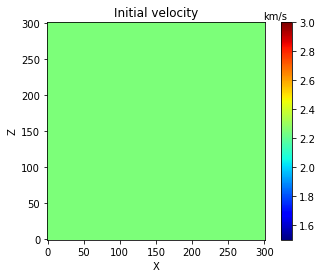

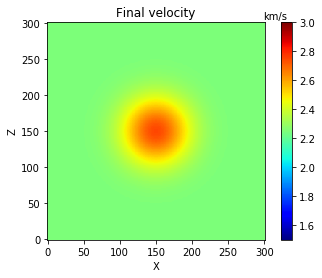

In [6]:
%matplotlib inline
# Plot models
vel_initial.plot_nopad(title="Initial velocity", vmin=v_min, vmax=v_max)
vel_final.plot_nopad(title="Final velocity", vmin=v_min, vmax=v_max)

## Deform along path the velocity model

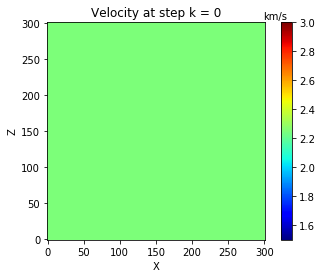

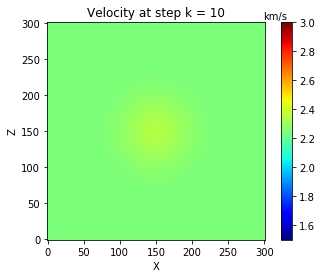

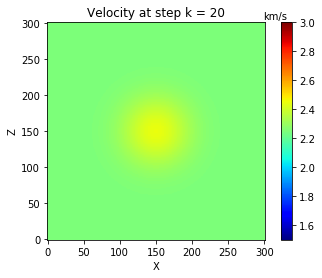

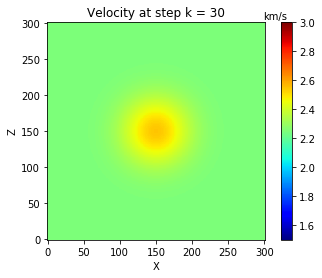

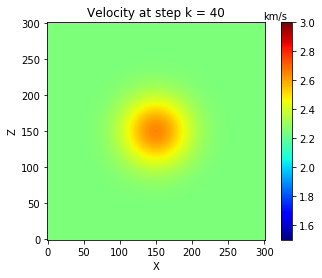

In [7]:
# Define steps to take
nsteps = 50

# Plot images every k steps
k = 10
v0 = vel_initial.get_vel()
vel_step = (vel_final.get_vel() - vel_initial.get_vel()) / nsteps

vel_model = Velocity2D(geometry2d=geom2d)
for i in range(0, nsteps, k):
    vel = v0 + i * vel_step
    vel_model.set_velocity(velocity=vel)
    vel_model.plot_nopad(title="Velocity at step k = " + str(i),  vmin=v_min, vmax=v_max)

## Some helper functions

In [8]:
def secondary_source_scattering(u, m0, m, omega, mu):
    """
    # Write a function that calculates the secondary source
    # m0 = (1/c0)^2, m = (1/c)^2
    
    # Inputs:
    # - u is a vector on Helmholtz grid
    # - m0, m are 2D vectors on Helmholtz grid
    
    # Outputs:
    # - output is flattened 1D vector
    """
    
    # Get dimensions of Helmholtz simulation area
    nx = ncells_x + 2 * ncells_x_pad - 1
    nz = ncells_z + 2 * ncells_z_pad - 1
    
    # Reshape u
    u = u.reshape((nx, nz))
    
    # Zero out padded zone
    u[0: ncells_x_pad - 1, :] = 0.0
    u[nx - ncells_x_pad + 1: nx, :] = 0.0
    u[:, 0: ncells_z_pad - 1] = 0.0
    u[:, nz - ncells_z_pad + 1: nz] = 0.0
    
    # Multiply by perturbation in slowness squared
    output = u * (m0 - m)
    output = output.reshape((nx * nz,))
    
    # Scale by omega^2 / (1 + omega^2 / mu^2)
    output *= (omega ** 2) / (1 + (omega ** 2) / (mu ** 2))
    
    # Restore u
    u = u.reshape((nx * nz,))
    
    return output

def scatter_add(u, matrix_factorized, m0, m, omega, mu):
    """
    # Scatter the wavefield once and add (Neumann series summation)
    # m0 = (1/c0)^2, m = (1/c)^2
    
    # Inputs:
    # - u is a vector on Helmholtz grid
    # - m0, m are 2D vectors on Helmholtz grid
    
    # Outputs:
    # - output is flattened 1D vector
    """
    
    # First calculate secondary source
    source_sec = secondary_source_scattering(
        u=u, 
        m0=m0, 
        m=m, 
        omega=omega, 
        mu=mu
    )
    
    # Solve the Helmholtz equation with rhs = source_sec
    source_sec = matrix_factorized.solve(source_sec)
    
    # Add to u
    u += source_sec

def scatter(u, matrix_factorized, m0, m, omega, mu):
    """
    # Scatter the wavefield once and add (Neumann series summation)
    # m0 = (1/c0)^2, m = (1/c)^2
    
    # Inputs:
    # - u is a vector on Helmholtz grid
    # - m0, m are 2D vectors on Helmholtz grid
    
    # Outputs:
    # - output is flattened 1D vector
    """
    
    # First calculate secondary source
    source_sec = secondary_source_scattering(
        u=u, 
        m0=m0, 
        m=m, 
        omega=omega, 
        mu=mu
    )
    
    # Solve the Helmholtz equation with rhs = source_sec
    source_sec = matrix_factorized.solve(source_sec)
    
    return source_sec

def plot_solution_nopad(
            u,
            title="Solution",
            xlabel="X",
            ylabel="Z",
            colorlabel="",
            vmin="",
            vmax="",
            cmap="jet",
            show=True,
            savefile=""
):
    
    """
    # Inputs:
    # - u is a 1D vector on Helmholtz grid
    """
    
    # Get dimensions of Helmholtz simulation area
    nx = ncells_x + 2 * ncells_x_pad - 1
    nz = ncells_z + 2 * ncells_z_pad - 1
    
    # Reshape u
    u_field = u.reshape((nx, nz))
    
    # Extract velocity field without padding region
    u_field = u_field[ncells_x_pad - 1: nx - ncells_x_pad + 1, ncells_z_pad - 1: nz - ncells_z_pad + 1]
    
    # Plot the velocity field
    if vmin is "":
        vmin = np.amin(u_field)
    if vmax is "":
        vmax = np.amax(u_field)

    plt.figure()
    plt.imshow(np.transpose(u_field), origin="lower", vmin=vmin, vmax=vmax, cmap=cmap)
    cb = plt.colorbar()
    cb.set_label(colorlabel, labelpad=-40, y=1.05, rotation=0)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    if savefile is not "":
        plt.savefig(savefile, bbox_inches="tight")

    if show:
        plt.show()

## Perform modeling for fixed frequency
Now perform modeling for a fixed frequency.

In [9]:
nsteps = 500
omega = 50.0

vel1 = vel_initial.get_vel()
vel_step = (vel_final.get_vel() - vel_initial.get_vel()) / nsteps
vel2 = vel1 + vel_step

vel_model1 = Velocity2D(geometry2d=geom2d)
vel_model1.set_velocity(velocity=vel1)
vel_model2 = Velocity2D(geometry2d=geom2d)
vel_model2.set_velocity(velocity=vel2)

# Create Helmoltz matrices for both models
mat1_helmholtz2d = CreateMatrixHelmholtz2D(velocity2d=vel_model1, pml_damping=Common.pml_damping)
mat1 = mat1_helmholtz2d.create_matrix(omega=omega)
mat1_fac = splu(mat1)
mat2_helmholtz2d = CreateMatrixHelmholtz2D(velocity2d=vel_model2, pml_damping=Common.pml_damping)
mat2 = mat2_helmholtz2d.create_matrix(omega=omega)
mat2_fac = splu(mat2)

# Create Helmoltz matrices for final model
mat3_helmholtz2d = CreateMatrixHelmholtz2D(velocity2d=vel_final, pml_damping=Common.pml_damping)
mat3 = mat3_helmholtz2d.create_matrix(omega=omega)
mat3_fac = splu(mat3)

Create right rand sides.

In [10]:
# Create rhs
ngridx = vel_initial.geometry2D.gridpointsX - 2
ngridz = vel_initial.geometry2D.gridpointsZ - 2
b = np.zeros(shape=(ngridx * ngridz), dtype=np.complex64)
b[int(0.8 * ngridx * ngridz / 2)] = 1000.0

# Solve Helmholtz equation for both models
u1 = mat1_fac.solve(b)
u2 = mat2_fac.solve(b)
u3 = mat3_fac.solve(b)

Plot true results.

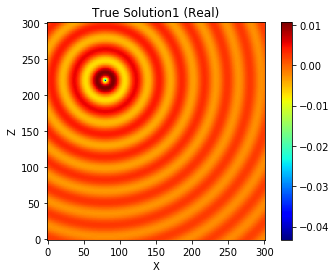

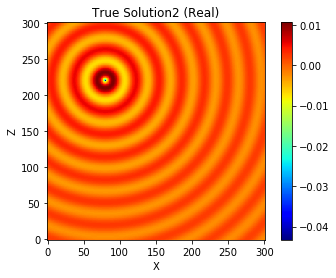

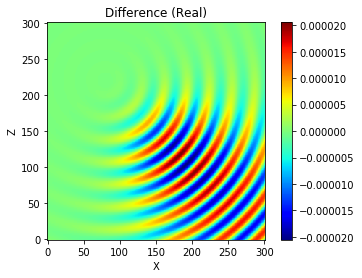

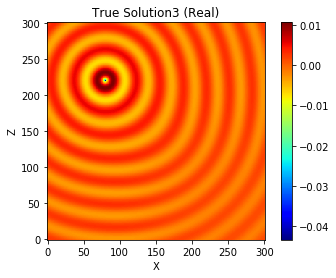

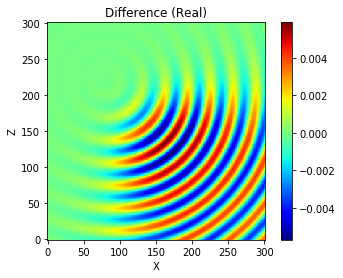

In [11]:
%matplotlib inline

plot_solution_nopad(
            u=np.real(u1),
            title="True Solution1 (Real)",
            xlabel="X",
            ylabel="Z",
            colorlabel="",
            vmin="",
            vmax="",
)

plot_solution_nopad(
            u=np.real(u2),
            title="True Solution2 (Real)",
            xlabel="X",
            ylabel="Z",
            colorlabel="",
            vmin="",
            vmax="",
)

plot_solution_nopad(
            u=np.real(u2 - u1),
            title="Difference (Real)",
            xlabel="X",
            ylabel="Z",
            colorlabel="",
            vmin="",
            vmax="",
)

plot_solution_nopad(
            u=np.real(u3),
            title="True Solution3 (Real)",
            xlabel="X",
            ylabel="Z",
            colorlabel="",
            vmin="",
            vmax="",
)

plot_solution_nopad(
            u=np.real(u3 - u1),
            title="Difference (Real)",
            xlabel="X",
            ylabel="Z",
            colorlabel="",
            vmin="",
            vmax="",
)

Neumann series summation.

Iteration = 0
0.6064844263661725


Iteration = 10
0.606484428595568


Iteration = 20
0.6064844354816472


Iteration = 30
0.606484447038508


Iteration = 40
0.6064844632804185




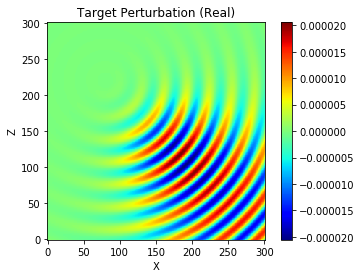

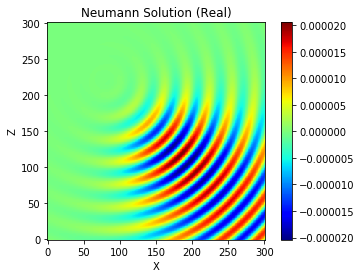

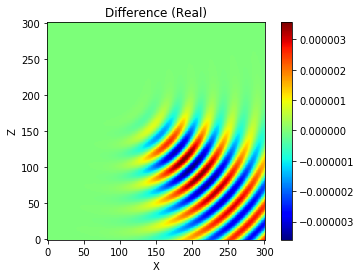

In [18]:
# Get dimensions of Helmholtz simulation area
nx = ncells_x + 2 * ncells_x_pad - 1
nz = ncells_z + 2 * ncells_z_pad - 1

m0 = 1.0 / (vel1 ** 2)
m = 1.0 / (vel2 ** 2)
m0 = m0[1: nx + 1, 1: nz + 1]
m = m[1: nx + 1, 1: nz + 1]

niter = 50
u_neumann = scatter(u=u1, matrix_factorized=mat1_fac, m0=m0, m=m, omega=omega, mu=1000)

for i in range(niter):
    scatter_add(u=u_neumann, matrix_factorized=mat1_fac, m0=m0, m=m, omega=omega, mu=1000)
    
    if i % 10 == 0:
        print("Iteration = " + str(i))
        print(np.linalg.norm(np.real(u_neumann - u2 + u1)))
        print("\n")

plot_solution_nopad(
            u=np.real(u2 - u1),
            title="Target Perturbation (Real)",
            xlabel="X",
            ylabel="Z",
            colorlabel="",
            vmin="",
            vmax="",
)

plot_solution_nopad(
            u=np.real(u_neumann),
            title="Neumann Solution (Real)",
            xlabel="X",
            ylabel="Z",
            colorlabel="",
            vmin="",
            vmax="",
)

plot_solution_nopad(
            u=np.real(u_neumann - u2 + u1),
            title="Difference (Real)",
            xlabel="X",
            ylabel="Z",
            colorlabel="",
            vmin="",
            vmax="",
)